# Visualize methods results

Import necessary libraries

Tensorflow version 2.15.0 is required to avoid errors

In [ ]:
!pip install tensorflow==2.15.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import joblib
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [4]:
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"Versión de joblib: {joblib.__version__}")

Versión de TensorFlow: 2.15.0
Versión de joblib: 1.4.2


Import data and models

In [5]:
from google.colab import drive
drive.mount('/content/drive')

path = "..."

Mounted at /content/drive


In [6]:
y_ML = np.load(path + 'y_pred_ML.npy')

y_true = np.load(path + 'y_test.npy')

In [7]:
y_scaler = joblib.load(path + 'y_scaler.pkl')

NN = keras.models.load_model(path + 'model.keras')
NV = keras.models.load_model(path + 'model_vario.keras')

In [8]:
X_test = np.load(path + 'X_test.npy')

In [9]:
%%time
y_NN = y_scaler.inverse_transform(NN.predict(X_test, verbose = 0))
y_NN

CPU times: user 10.2 s, sys: 907 ms, total: 11.1 s
Wall time: 11 s


array([[ 2.9754958 ,  1.0755041 ,  0.40732938],
       [ 2.9919553 ,  1.1226196 ,  0.35933584],
       [-0.04059816,  1.0856032 ,  0.29407984],
       ...,
       [ 0.65586674,  3.102117  ,  0.8185899 ],
       [ 0.67379594,  3.0900068 ,  0.76070887],
       [ 0.15263999,  2.8015327 ,  0.5997715 ]], dtype=float32)

In [10]:
X_test_vario = np.load(path + 'X_test_vario.npy')

In [11]:
%%time
y_NV = y_scaler.inverse_transform(NV.predict(X_test_vario, verbose = 0))
y_NV

CPU times: user 8.16 s, sys: 652 ms, total: 8.82 s
Wall time: 10.8 s


array([[ 0.06645441,  1.0710648 ,  0.37913957],
       [-0.00959945,  1.1967041 ,  0.3742605 ],
       [-0.02616585,  1.0271382 ,  0.26993448],
       ...,
       [ 0.38786173,  2.9194722 ,  0.712079  ],
       [ 0.75245917,  3.052807  ,  0.8501948 ],
       [ 2.8722484 ,  2.6295307 ,  0.53547156]], dtype=float32)

In [12]:
y_NV[y_NV<0] = 0
y_NN[y_NN<0] = 0

## $\alpha$

In [ ]:
results_alpha = pd.concat((
    pd.DataFrame({'alpha':y_true[:,0], "pred_alpha":y_NN[:,0], "Método":"NF"}),
    pd.DataFrame({'alpha':y_true[:,0], "pred_alpha":y_NV[:,0], "Método":"NV"}),
    pd.DataFrame({'alpha':y_true[:,0], "pred_alpha":y_ML[:,0], "Método":"ML"})
))

In [ ]:
results_alpha['diff_alpha'] = results_alpha['pred_alpha'] - results_alpha['alpha']
results_alpha['bin_alpha']  = pd.cut(results_alpha['alpha'], bins=10).apply(lambda x: (x.left + x.right) / 2).astype(float)

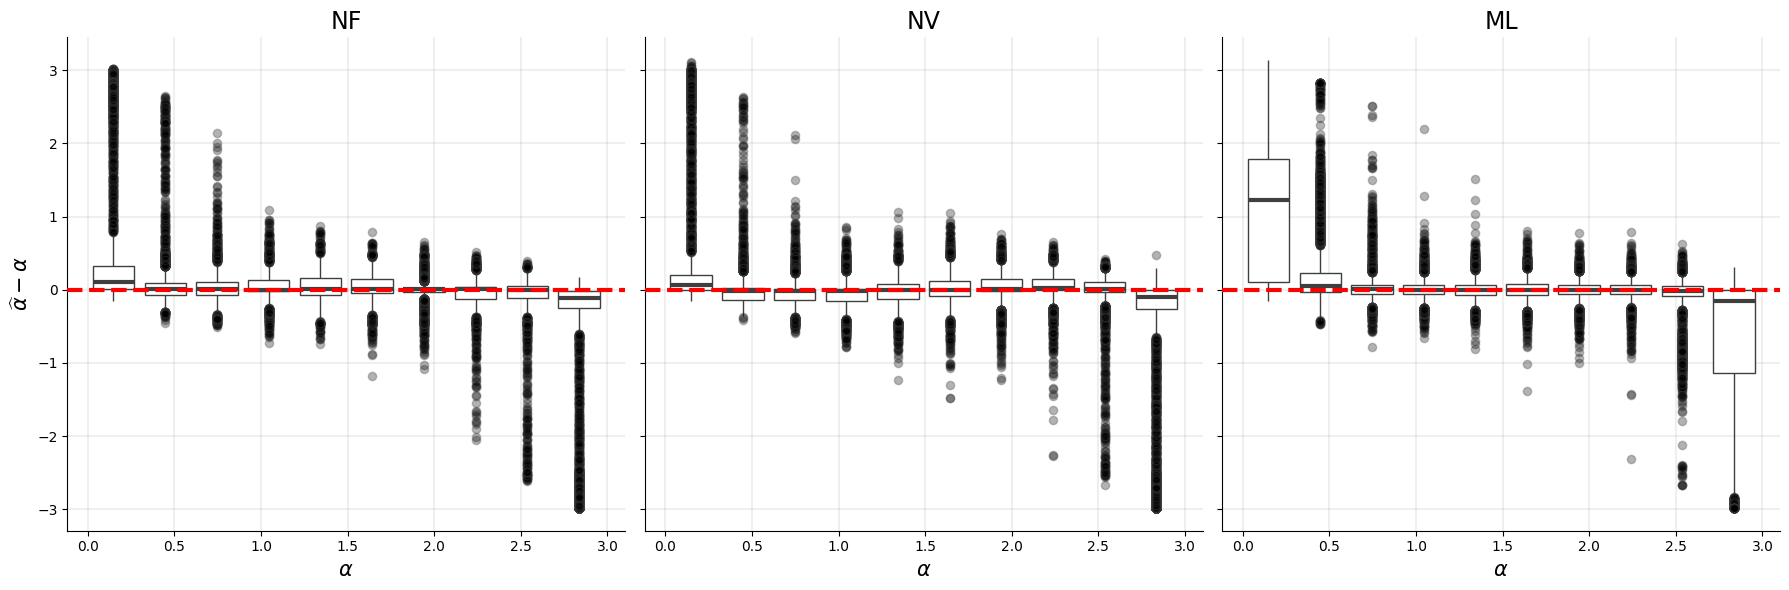

In [ ]:
g = sns.FacetGrid(results_alpha, col="Método", col_wrap=3, sharey=True, height=6)

for ax in g.axes:
    ax.grid(alpha=0.2, lw=1.5, zorder=1)
    ax.axhline(0, ls='--', lw=3, c='r', zorder=3)
    # ax.axvspan(-0.5, 4.5, color='red', alpha=0.1, zorder=0)
    # ax.axvspan(4.5, 9.5, color='blue', alpha=0.1, zorder=0)

g.map(sns.boxplot, "bin_alpha", "diff_alpha", zorder=2, native_scale=True,
      boxprops={"facecolor": 'white'}, showcaps=False, showfliers=True,
      medianprops={"lw": 3}, flierprops={"marker": "o", 'alpha':0.3, 'markerfacecolor':'black'},)

g.set_axis_labels(r'$\alpha$', r'$\widehat{\alpha}-\alpha$', size=15)
g.set_titles(col_template="{col_name}", size=17)

plt.tight_layout()

g.savefig(path + 'Figures/alpha_boxplot.png', dpi=200);

In [ ]:
aux = results_alpha[results_alpha['bin_alpha'].isin(results_alpha['bin_alpha'].unique()[[0, -1]])]

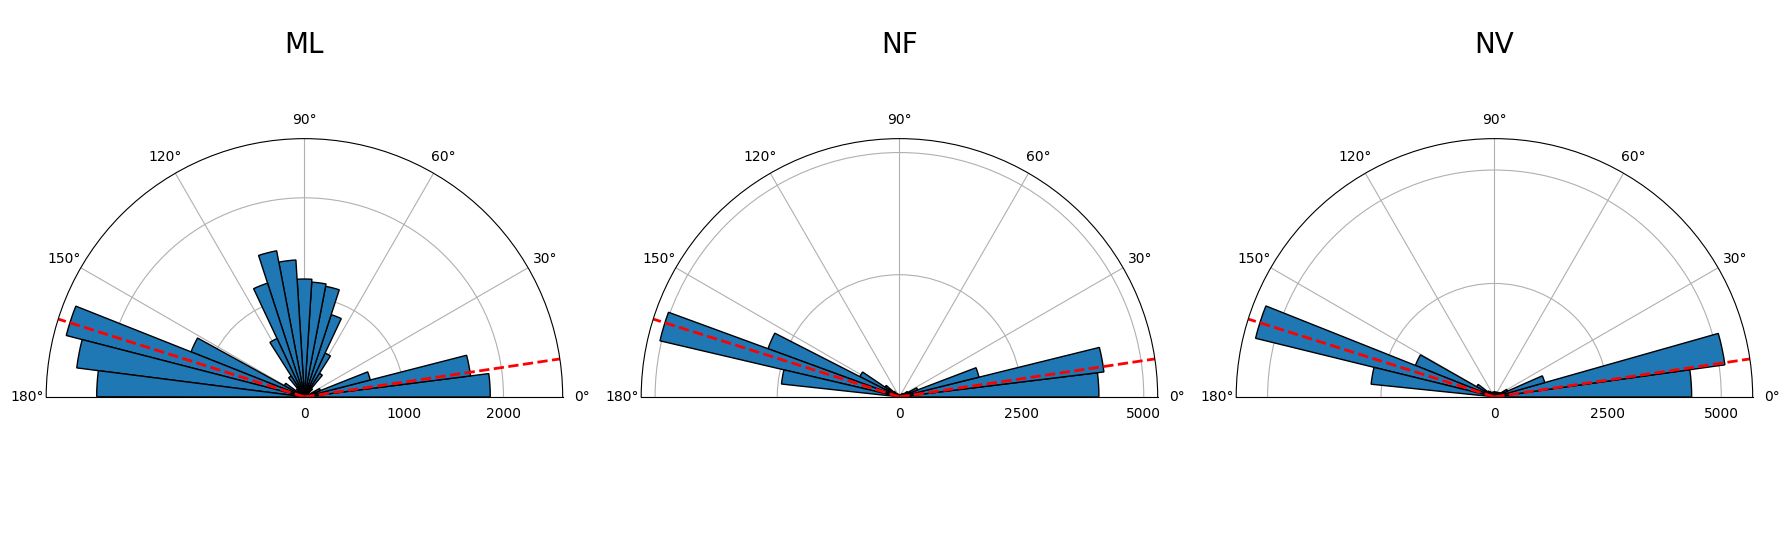

In [ ]:
num_bins = 25
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'polar': True})
for ax, (name, group) in zip(axs.flatten(), aux.groupby('Método')):
  values = ax.hist(group['pred_alpha'], edgecolor='k', bins=num_bins, zorder=2)
  for angle in group['bin_alpha'].unique():
    ax.axvline(angle, c='r', lw=2, ls='--')
  ax.set_title(name, size=20, y = 0.9)
  ax.set_xlim(0, np.pi)
  ax.set_yticks(np.arange(0,max(values[0]), 1_000)) if max(values[0]) < 3000 else ax.set_yticks(np.arange(0,max(values[0]), 2_500))
fig.tight_layout()
fig.savefig(path + 'Figures/alpha_polar.png', dpi=200, bbox_inches='tight')

### Extra

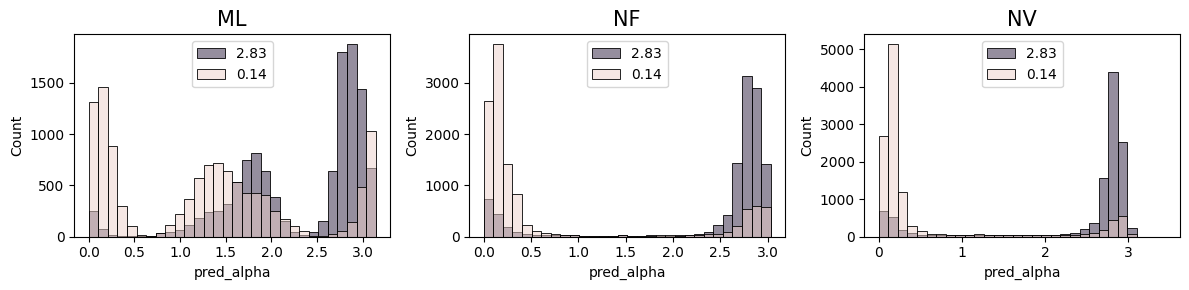

In [ ]:
num_bins = 30

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for ax, (name, group) in zip(axs.flatten(), aux.groupby('Método')):
  sns.histplot(group, x = 'pred_alpha', hue='bin_alpha', edgecolor='k', bins=num_bins, ax=ax)
  # for angle in group['bin_alpha'].unique():
  #   ax.axvline(angle, c='r', lw=2, ls='--')
  ax.legend([2.83, 0.14], loc='upper center')
  ax.set_title(name, size=15)
fig.tight_layout()

In [ ]:
scatter_alpha = pd.concat([
    (
    results_alpha[results_alpha.bin_alpha > results_alpha.bin_alpha.unique()[4]]
        .groupby('Método')
        .agg(mean=('diff_alpha', 'mean'), std=('diff_alpha', 'std'))
        .assign(Lado='Der')
        .reset_index()
    ),
    (
    results_alpha[results_alpha.bin_alpha <= results_alpha.bin_alpha.unique()[4]]
    .groupby('Método')
    .agg(mean=('diff_alpha', 'mean'), std=('diff_alpha', 'std'))
    .assign(Lado='Izq')
    .reset_index()
    )
])
scatter_alpha

,Método,mean,std,Lado
0,ML,-0.132786,0.431292,Der
1,NN,-0.108610,0.497239,Der
2,NV,-0.087489,0.510146,Der
0,ML,0.294916,0.693814,Izq
1,NN,0.145627,0.562627,Izq
2,NV,0.072880,0.484781,Izq


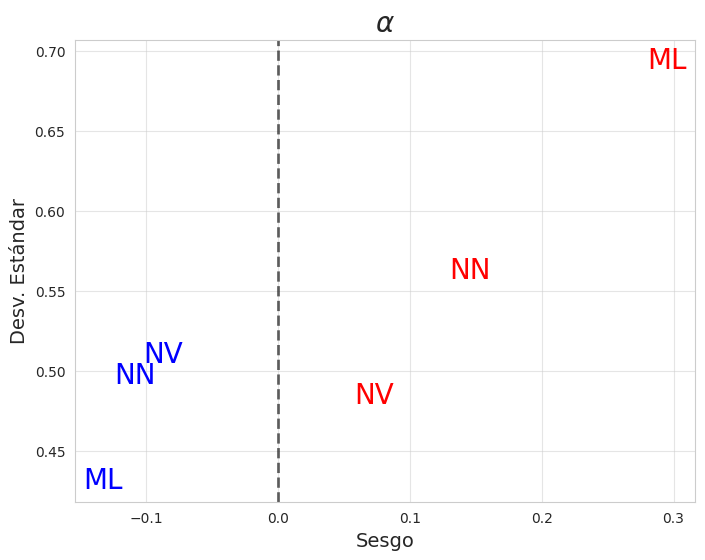

In [ ]:
color = {'Der':'b', 'Izq': 'r'}

plt.figure(figsize=(8,6))
sns.scatterplot(data=scatter_alpha,x='mean',y='std',alpha=0)
for i, row in scatter_alpha.iterrows():
    plt.text(row['mean'], row['std'], row['Método'],
             fontsize=20, color=color[row['Lado']], ha='center', va='center')

plt.axvline(x=0, color='k', ls='--', lw=2, alpha=0.6)
plt.title(r'$\alpha$', size=20); plt.grid(alpha=0.5)
plt.xlabel('Sesgo', size=14); plt.ylabel('Desv. Estándar', size=14);

### Details

In [ ]:
alpha_info = (
    results_alpha
    .groupby(['alpha', 'Método'])
    .agg(bias=('diff_alpha', 'mean'), std=('diff_alpha', 'std'))
    .reset_index()
)
alpha_info.to_csv(path+'Detalle/alpha.csv', index=False)

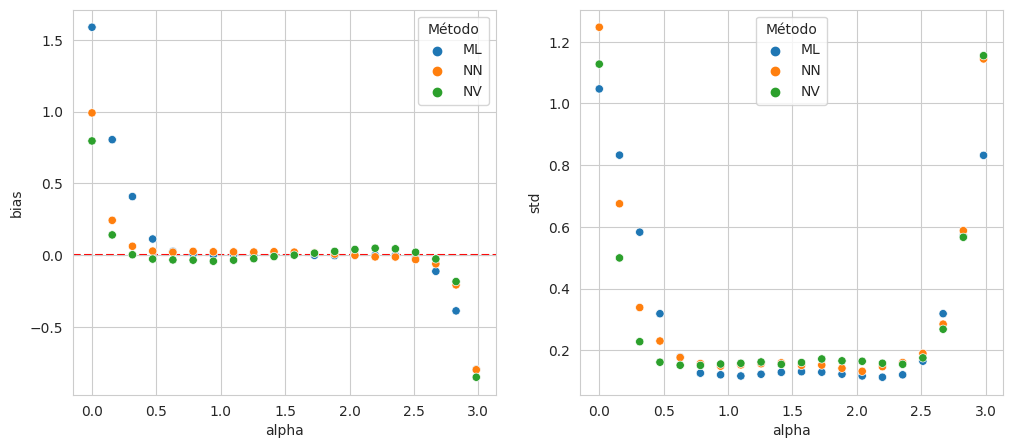

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(12,5))

sns.scatterplot(x='alpha', y='bias', hue='Método', data=alpha_info, ax=ax1)
ax1.axhline(0, ls='--', lw=1.5, c='r', zorder=0)
sns.scatterplot(x='alpha', y='std', hue='Método', data=alpha_info, ax=ax2);

In [ ]:
alpha_info_suavizada = (
    results_alpha
    .groupby(['bin_alpha', 'Método'])
    .agg(bias=('diff_alpha', 'mean'), std=('diff_alpha', 'std'))
    .reset_index()
)

alpha_info_suavizada.to_csv(path+'Detalle/bin_alpha.csv', index=False)

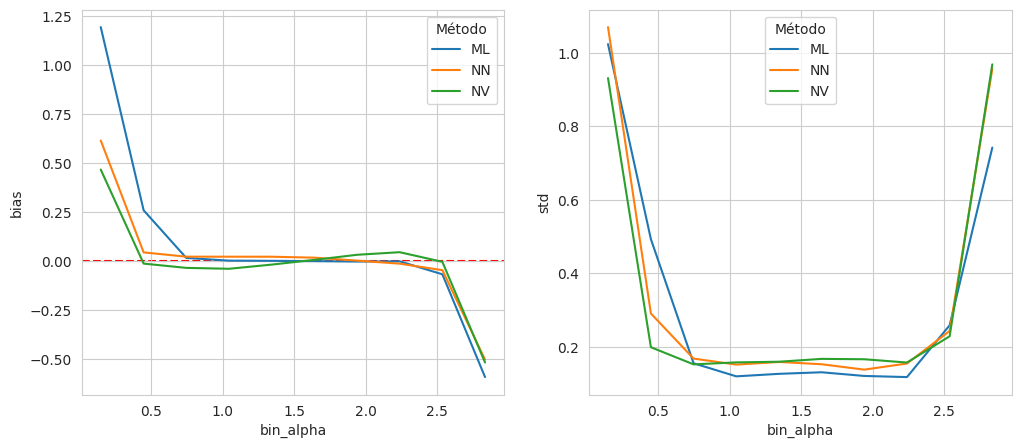

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(12,5))

sns.lineplot(x='bin_alpha', y='bias', hue='Método', data=alpha_info_suavizada, ax=ax1)
ax1.axhline(0, ls='--', lw=1.5, c='r', zorder=0)
sns.lineplot(x='bin_alpha', y='std', hue='Método', data=alpha_info_suavizada, ax=ax2);

In [ ]:
# REDONDEAMOS LOS VALORES A 4 DECIMALES
alpha_info_suavizada[['bin_alpha', 'bias', 'std']] = alpha_info_suavizada[['bin_alpha', 'bias', 'std']].round(4)

alpha_info_suavizada = alpha_info_suavizada.pivot(index='bin_alpha', columns='Método', values=['bias', 'std'])
alpha_info_suavizada

bias                     std                
Método         ML      NN      NV      ML      NN      NV
bin_alpha                                                
0.1475     1.1955  0.6161  0.4676  1.0239  1.0703  0.9314
0.4475     0.2595  0.0444 -0.0129  0.4927  0.2903  0.1985
0.7460     0.0160  0.0225 -0.0347  0.1548  0.1676  0.1518
1.0445     0.0024  0.0224 -0.0393  0.1192  0.1512  0.1572
1.3430     0.0012  0.0223 -0.0180  0.1260  0.1584  0.1590
1.6415    -0.0003  0.0175  0.0062  0.1303  0.1521  0.1668
1.9400    -0.0023  0.0024  0.0322  0.1203  0.1375  0.1657
2.2385    -0.0013 -0.0131  0.0454  0.1172  0.1541  0.1568
2.5370    -0.0674 -0.0464 -0.0038  0.2582  0.2428  0.2283
2.8355    -0.5926 -0.5035 -0.5179  0.7421  0.9565  0.9687

In [ ]:
# FORMATO TABLA LATEX
alpha_info_suavizada.to_csv(path+'Detalle/alpha.txt', sep='&', line_terminator='\\\\')

## $\theta$

In [ ]:
results_theta = pd.concat((
    pd.DataFrame({'theta':y_true[:,1], "pred_theta":y_NN[:,1], "Método":"NF"}),
    pd.DataFrame({'theta':y_true[:,1], "pred_theta":y_NV[:,1], "Método":"NV"}),
    pd.DataFrame({'theta':y_true[:,1], "pred_theta":y_ML[:,1], "Método":"ML"})
))
results_theta['diff_theta'] = results_theta['pred_theta'] - results_theta['theta']
results_theta['bin_theta'] = pd.cut(results_theta['theta'], bins=10).apply(lambda x: (x.left + x.right) / 2).astype(float)

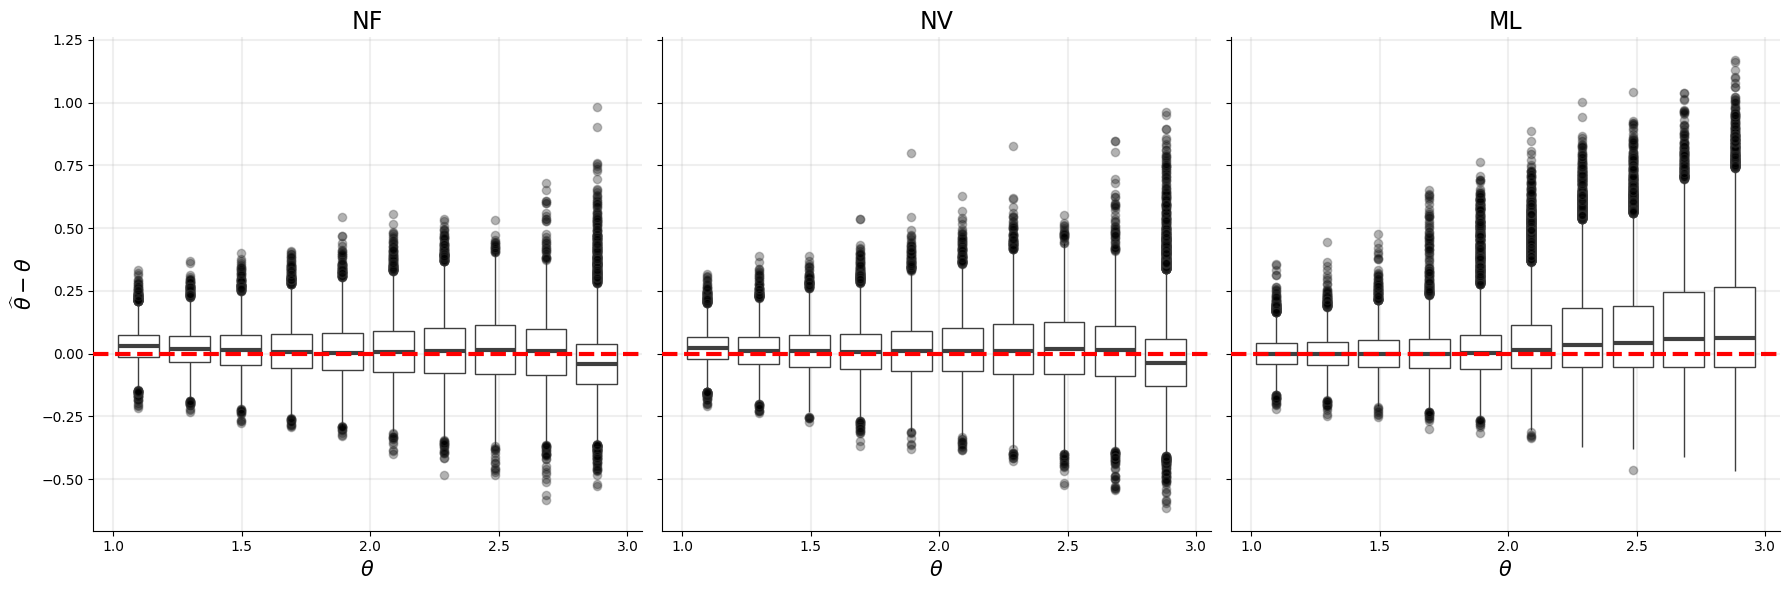

In [ ]:
g = sns.FacetGrid(results_theta, col="Método", col_wrap=3, sharey=True, height=6)

for ax in g.axes:
    ax.grid(alpha=0.2, lw=1.5, zorder=1)
    ax.axhline(0, ls='--', lw=3, c='r', zorder=3)
    ax.set_xticks([1,1.5,2,2.5,3])
    # ax.axvspan(-0.5, 4.5, color='red', alpha=0.1, zorder=0)
    # ax.axvspan(4.5, 9.5, color='blue', alpha=0.1, zorder=0)

g.map(sns.boxplot, "bin_theta", "diff_theta", zorder=2, native_scale=True,
      boxprops={"facecolor": 'white'}, showcaps=False, showfliers=True,
      medianprops={"lw": 3}, flierprops={"marker": "o", 'alpha':0.3, 'markerfacecolor':'black'},)


g.set_axis_labels(r'$\theta$', r'$\widehat{\theta}-\theta$', size=15)
g.set_titles(col_template="{col_name}", size=17)

plt.tight_layout()

g.savefig(path + 'Figures/theta_boxplot.png', dpi=200);

### Extra

In [ ]:
scatter_theta = pd.concat([
    (
    results_theta[results_theta.bin_theta > results_theta.bin_theta.unique()[4]]
        .groupby('Método')
        .agg(mean=('diff_theta', 'mean'), std=('diff_theta', 'std'))
        .assign(Lado='Der')
        .reset_index()
    ),
    (
    results_theta[results_theta.bin_theta <= results_theta.bin_theta.unique()[4]]
    .groupby('Método')
    .agg(mean=('diff_theta', 'mean'), std=('diff_theta', 'std'))
    .assign(Lado='Izq')
    .reset_index()
    )
])
scatter_theta

,Método,mean,std,Lado
0,ML,0.095373,0.217933,Der
1,NN,0.002208,0.135693,Der
2,NV,0.007182,0.151728,Der
0,ML,0.006185,0.088722,Izq
1,NN,0.019244,0.089390,Izq
2,NV,0.016207,0.093521,Izq


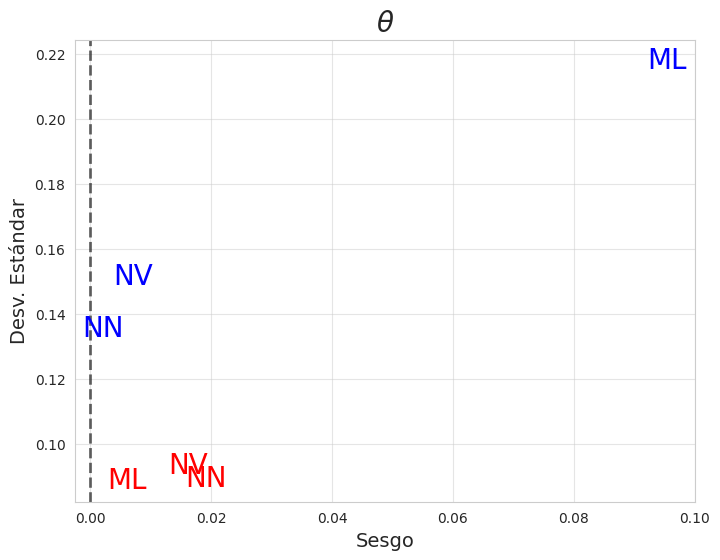

In [ ]:
color = {'Der':'b', 'Izq': 'r'}

plt.figure(figsize=(8,6))
sns.scatterplot(data=scatter_theta,x='mean',y='std',alpha=0)
for i, row in scatter_theta.iterrows():
    plt.text(row['mean'], row['std'], row['Método'],
             fontsize=20, color=color[row['Lado']], ha='center', va='center')

plt.axvline(x=0, color='k', ls='--', lw=2, alpha=0.6)
plt.title(r'$\theta$', size=20); plt.grid(alpha=0.5)
plt.xlabel('Sesgo', size=14); plt.ylabel('Desv. Estándar', size=14);

### Details

In [ ]:
theta_info = (
    results_theta
    .groupby(['theta', 'Método'])
    .agg(bias=('diff_theta', 'mean'), std=('diff_theta', 'std'))
    .reset_index()
)

theta_info.to_csv(path+'Detalle/theta.csv', index=False)

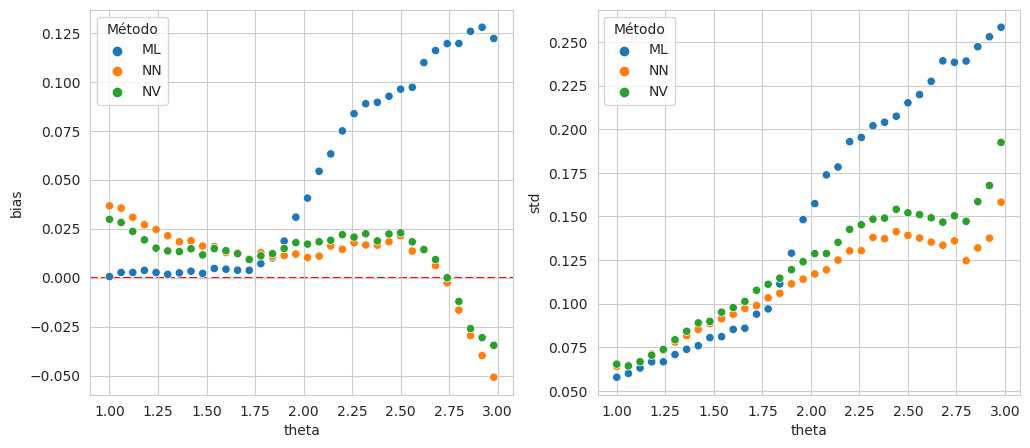

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(12,5))

sns.scatterplot(x='theta', y='bias', hue='Método', data=theta_info, ax=ax1)
ax1.axhline(0, ls='--', lw=1.5, c='r', zorder=0)
sns.scatterplot(x='theta', y='std', hue='Método', data=theta_info, ax=ax2);

In [ ]:
theta_info_suavizada = (
    results_theta
    .groupby(['bin_theta', 'Método'])
    .agg(bias=('diff_theta', 'mean'), std=('diff_theta', 'std'))
    .reset_index()
)
theta_info_suavizada.to_csv(path+'Detalle/bin_theta.csv', index=False)

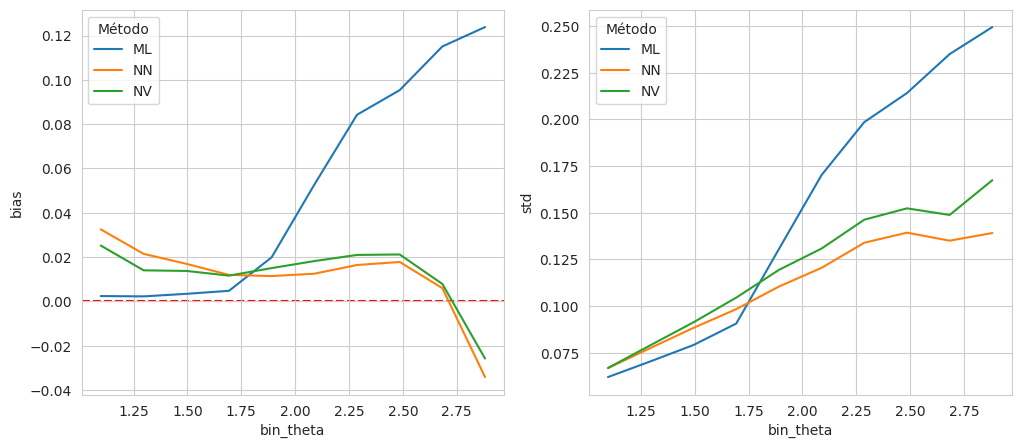

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(12,5))

sns.lineplot(x='bin_theta', y='bias', hue='Método', data=theta_info_suavizada, ax=ax1)
ax1.axhline(0, ls='--', lw=1.5, c='r', zorder=0)
sns.lineplot(x='bin_theta', y='std', hue='Método', data=theta_info_suavizada, ax=ax2);

In [ ]:
# REDONDEAMOS LOS VALORES A 4 DECIMALES
theta_info_suavizada[['bin_theta', 'bias', 'std']] = theta_info_suavizada[['bin_theta', 'bias', 'std']].round(4)

theta_info_suavizada = theta_info_suavizada.pivot(index='bin_theta', columns='Método', values=['bias', 'std'])
theta_info_suavizada

bias                     std                
Método         ML      NN      NV      ML      NN      NV
bin_theta                                                
1.098      0.0024  0.0325  0.0252  0.0620  0.0668  0.0669
1.297      0.0022  0.0214  0.0140  0.0705  0.0777  0.0792
1.495      0.0034  0.0169  0.0137  0.0792  0.0884  0.0914
1.693      0.0048  0.0119  0.0116  0.0907  0.0984  0.1046
1.891      0.0199  0.0114  0.0150  0.1306  0.1105  0.1194
2.089      0.0527  0.0125  0.0182  0.1703  0.1205  0.1309
2.287      0.0842  0.0164  0.0210  0.1986  0.1340  0.1463
2.485      0.0953  0.0178  0.0212  0.2142  0.1394  0.1524
2.683      0.1151  0.0060  0.0078  0.2350  0.1351  0.1489
2.881      0.1238 -0.0342 -0.0258  0.2495  0.1392  0.1675

In [ ]:
# FORMATO TABLA LATEX
theta_info_suavizada.to_csv(path+'Detalle/theta.txt', sep='&', line_terminator='\\\\')

## $\lambda$

In [ ]:
results_ratio = pd.concat((
    pd.DataFrame({'ratio':y_true[:,2], "pred_ratio":y_NN[:,2], "Método":"NF"}),
    pd.DataFrame({'ratio':y_true[:,2], "pred_ratio":y_NV[:,2], "Método":"NV"}),
    pd.DataFrame({'ratio':y_true[:,2], "pred_ratio":y_ML[:,2], "Método":"ML"})
))
results_ratio['diff_ratio'] = results_ratio['pred_ratio'] - results_ratio['ratio']
results_ratio['bin_ratio'] = pd.cut(results_ratio['ratio'], bins=10).apply(lambda x: (x.left + x.right) / 2).astype(float)

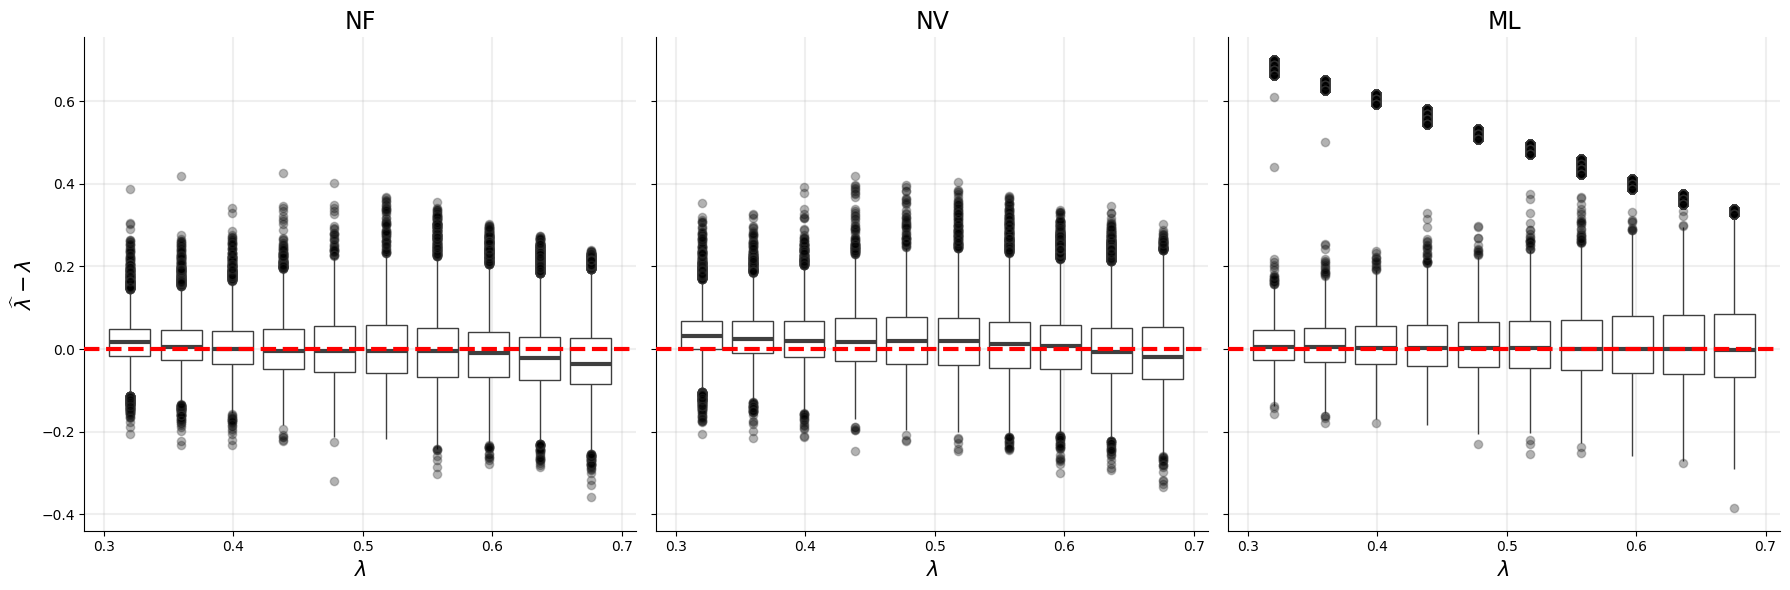

In [ ]:
g = sns.FacetGrid(results_ratio, col="Método", col_wrap=3, sharey=True, height=6)

for ax in g.axes:
    ax.grid(alpha=0.2, lw=1.5, zorder=1)
    ax.axhline(0, ls='--', lw=3, c='r', zorder=3)
    ax.set_xticks([.3,.4,.5,.6,.7])
    # ax.axvspan(-0.5, 4.5, color='red', alpha=0.1, zorder=0)
    # ax.axvspan(4.5, 9.5, color='blue', alpha=0.1, zorder=0)

g.map(sns.boxplot, "bin_ratio", "diff_ratio", zorder=2, native_scale=True,
      boxprops={"facecolor": 'white'}, showcaps=False, showfliers=True,
      medianprops={"lw": 3}, flierprops={"marker": "o", 'alpha':0.3, 'markerfacecolor':'black'},)

g.set_axis_labels(r'$\lambda$', r'$\widehat{\lambda}-\lambda$', size=15)
g.set_titles(col_template="{col_name}", size=17)

plt.tight_layout()

g.savefig(path + 'Figures/lambda_boxplot.png', dpi=200);

### Extra

In [ ]:
scatter_ratio = pd.concat([
    (
    results_ratio[results_ratio.bin_ratio > results_ratio.bin_ratio.unique()[4]]
        .groupby('Método')
        .agg(mean=('diff_ratio', 'mean'), std=('diff_ratio', 'std'))
        .assign(Lado='Der')
        .reset_index()
    ),
    (
    results_ratio[results_ratio.bin_ratio <= results_ratio.bin_ratio.unique()[4]]
    .groupby('Método')
    .agg(mean=('diff_ratio', 'mean'), std=('diff_ratio', 'std'))
    .assign(Lado='Izq')
    .reset_index()
    )
])
scatter_ratio

,Método,mean,std,Lado
0,ML,0.041013,0.155032,Der
1,NN,-0.011070,0.090342,Der
2,NV,0.008409,0.092036,Der
0,ML,0.068239,0.201508,Izq
1,NN,0.009069,0.066316,Izq
2,NV,0.028809,0.069019,Izq


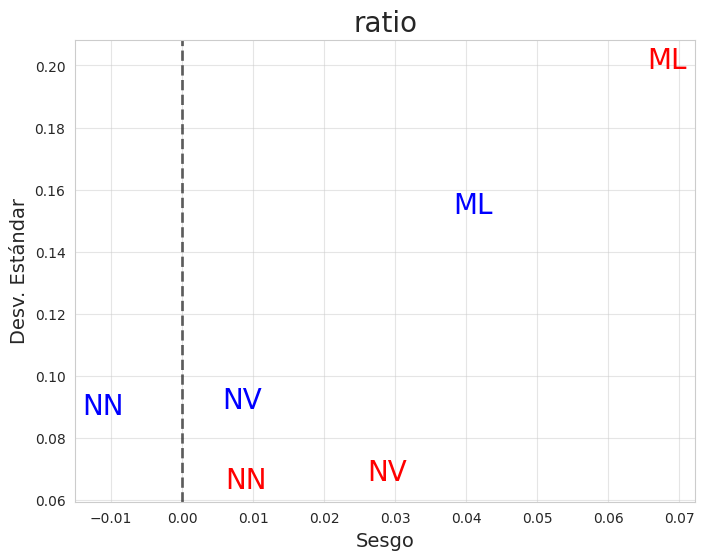

In [ ]:
color = {'Der':'b', 'Izq': 'r'}

plt.figure(figsize=(8,6))
sns.scatterplot(data=scatter_ratio,x='mean',y='std',alpha=0)
for i, row in scatter_ratio.iterrows():
    plt.text(row['mean'], row['std'], row['Método'],
             fontsize=20, color=color[row['Lado']], ha='center', va='center')

plt.axvline(x=0, color='k', ls='--', lw=2, alpha=0.6)
plt.title(r'ratio', size=20); plt.grid(alpha=0.5)
plt.xlabel('Sesgo', size=14); plt.ylabel('Desv. Estándar', size=14);

### Details

In [ ]:
ratio_info = (
    results_ratio
    .groupby(['ratio', 'Método'])
    .agg(bias=('diff_ratio', 'mean'), std=('diff_ratio', 'std'))
    .reset_index()
)
ratio_info.to_csv(path+'Detalle/ratio.csv', index=False)

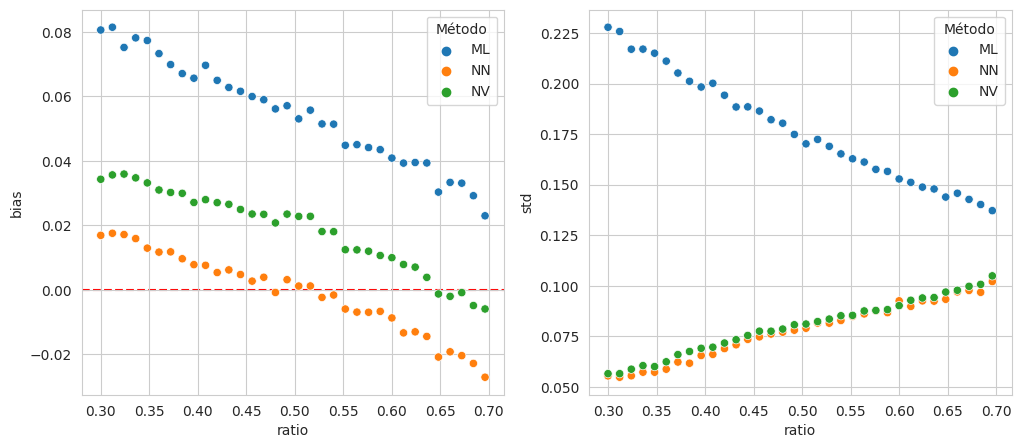

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(12,5))

sns.scatterplot(x='ratio', y='bias', hue='Método', data=ratio_info, ax=ax1)
ax1.axhline(0, ls='--', lw=1.5, c='r', zorder=0)
sns.scatterplot(x='ratio', y='std', hue='Método', data=ratio_info, ax=ax2);

In [ ]:
ratio_info_suavizada = (
    results_ratio
    .groupby(['bin_ratio', 'Método'])
    .agg(bias=('diff_ratio', 'mean'), std=('diff_ratio', 'std'))
    .reset_index()
)
ratio_info_suavizada.to_csv(path+'Detalle/bin_ratio.csv', index=False)

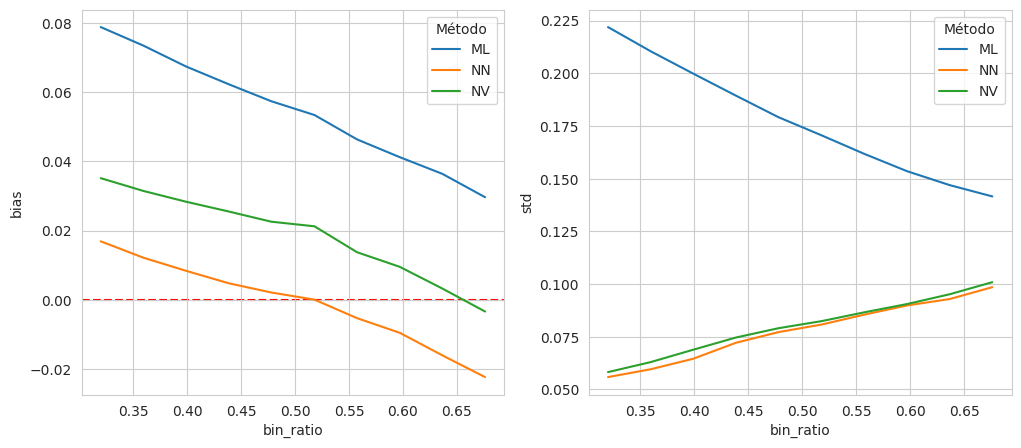

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(12,5))

sns.lineplot(x='bin_ratio', y='bias', hue='Método', data=ratio_info_suavizada, ax=ax1)
ax1.axhline(0, ls='--', lw=1.5, c='r', zorder=0)
sns.lineplot(x='bin_ratio', y='std', hue='Método', data=ratio_info_suavizada, ax=ax2);

In [ ]:
# REDONDEAMOS LOS VALORES A 4 DECIMALES
ratio_info_suavizada[['bin_ratio', 'bias', 'std']] = ratio_info_suavizada[['bin_ratio', 'bias', 'std']].round(4)

ratio_info_suavizada = ratio_info_suavizada.pivot(index='bin_ratio', columns='Método', values=['bias', 'std'])
ratio_info_suavizada

bias                     std                
Método         ML      NN      NV      ML      NN      NV
bin_ratio                                                
0.3200     0.0789  0.0169  0.0352  0.2219  0.0558  0.0582
0.3595     0.0735  0.0121  0.0315  0.2104  0.0595  0.0629
0.3990     0.0675  0.0084  0.0283  0.1998  0.0645  0.0688
0.4385     0.0623  0.0047  0.0255  0.1894  0.0721  0.0746
0.4780     0.0574  0.0021  0.0226  0.1791  0.0772  0.0790
0.5180     0.0534  0.0000  0.0212  0.1705  0.0808  0.0824
0.5575     0.0464 -0.0054  0.0137  0.1617  0.0855  0.0866
0.5970     0.0412 -0.0096  0.0095  0.1535  0.0898  0.0905
0.6365     0.0364 -0.0161  0.0032  0.1469  0.0929  0.0951
0.6760     0.0297 -0.0224 -0.0034  0.1416  0.0985  0.1009

In [ ]:
# FORMATO TABLA LATEX
ratio_info_suavizada.to_csv(path+'Detalle/ratio.txt', sep='&', line_terminator='\\\\')